In [1]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.6 MB/s 
     |████████████████████████████████| 144 kB 39.7 MB/s 
     |████████████████████████████████| 181 kB 46.1 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=a2016e75847244d16310efce6ffebafafa879d91182654f0c2ca798e57b61b01
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [3]:
#wandb integration
import wandb

In [4]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.


In [8]:
!pip install tensorflow-gpu

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [6]:


import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
#from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
#import tensorflow_probability as tfp

## DQN

Using NNs as substitutes isn't something new. It has been tried earlier, but the 'human control' paper really popularised using NNs by providing a few stability ideas (Q-Targets, Experience Replay & Truncation). The 'Deep-Q Network' (DQN) Algorithm can be broken down into having the following components. 

### Q-Network:
The neural network used as a function approximator is defined below

In [7]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 64 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()

QNetwork2: Feel free to experiment more
'''

import torch
import torch.nn as nn  
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
#BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
#BATCH_SIZE = 64         #''' minibatch size '''
#GAMMA = 0.99            #''' discount factor '''
#LR = 5e-4               #''' learning rate '''
#UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''


class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay Buffer:

This is a 'deque' that helps us store experiences. Recall why we use such a technique.

In [8]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Truncation:
We add a line (optionally) in the code to truncate the gradient in hopes that it would help with the stability of the learning process.

## Agent Code:


In [9]:
from scipy.special import softmax
import random

class Agent():

    def __init__(self, state_size, action_size, seed,\
                 method='softmax',temp=0.9,buffer_size = int(1e5),\
                batch_size = 64 ,gamma = 0.99,lr = 5e-4,update_every = 20,\
                 fc1_units=128, fc2_units=64,momentum_decay =0.9,\
                optimizer='adam'):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.method=method
        self.temp=temp
        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed,fc1_units,fc2_units).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed,fc1_units,fc2_units).to(device)
        self.optimizer =None
        if(optimizer=='adam'):
            self.optimizer=optim.Adam(self.qnetwork_local.parameters(), lr=lr)
        if(optimizer=='nadam'):
            self.optimizer=optim.NAdam(self.qnetwork_local.parameters(), lr=lr,momentum_decay=momentum_decay)
        if(optimizer=='RMSprop'):
            self.optimizer=optim.RMSprop(self.qnetwork_local.parameters(), lr=lr)
        if(optimizer=='nesterov'):
            self.optimizer=optim.SGD(self.qnetwork_local.parameters(), lr=lr,nesterov =True,isprint=False)
        self.batch_size=batch_size
        self.gamma=gamma
        self.lr=lr
        self.update_every=update_every
        self.buffer_size=buffer_size
        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, seed)

        ''' Initialize time step (for updating every update_every steps)           -Needed for Q Targets '''
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)
        
        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'update_every' steps taken '''      
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def actWithEpsilon(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    


    def actWithSoftMax(self, state,temperature):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        convertNumpy=action_values.cpu().data.numpy()
        convertNumpy=convertNumpy[0]
        if(temperature!=0):
             convertNumpy/=temperature
        sofrmX=softmax(convertNumpy)
        sofrmX/=sofrmX.sum()
        if(temperature==0):
          return np.argmax(sofrmX)
        all_possible_actions = np.arange(0, sofrmX.shape[-1])
        action = np.random.choice(all_possible_actions,p=sofrmX)
        return action
    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()

In [10]:
''' Defining DQN Algorithm '''
def dqn(agent,n_episodes=10000, scoreThreshold=100,\
        max_t=1000, eps_start=1.0, eps_end=0.01,\
        eps_decay=0.995,method='softmax',temperature=0.9,buffer_size = int(1e5),\
        batch_size = 64 ,gamma = 0.99,LR = 5e-4,update_every = 20,wandbLog=False,isprint=True,temp_decay=0,temp_end=0.0001):

    scores = []
    steps = []    
    ''' list containing scores from each episode '''

    scores_window_printing = deque(maxlen=10) 
    ''' For printing in the graph '''
    
    scores_window= deque(maxlen=100)  
    ''' last 100 scores for checking if the avg is more than 195 '''
    
    eps = eps_start                    
    ''' initialize epsilon '''
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        step=0
        for t in range(max_t):
            action=None
            if(method=='epsilon'):
              action = agent.actWithEpsilon(state, eps)
            else:
              action = agent.actWithSoftMax(state, temperature)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                step=t
                break 

        scores_window.append(score)  
        steps.append(step)
        scores_window_printing.append(score)   
        ''' save most recent score '''           

        eps = max(eps_end, eps_decay*eps) 
        #use exponential decay to reduce temperature
        if(temp_decay>0):
          temperature=max(temp_end,temp_decay*temperature  )
        ''' decrease epsilon '''
        if(isprint):
          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")  
        if i_episode % 10 == 0: 
            scores.append(np.mean(scores_window_printing))        
        if i_episode % 100 == 0:
           if(wandbLog): 
              wandb.log({'reward':  np.mean(scores_window),'step': i_episode})
           if(isprint):
              print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=scoreThreshold:
          if(isprint):
              print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'\
                 .format(i_episode-100, np.mean(scores_window)))
              break
    return [np.array(scores),i_episode-100],np.array(scores_window),np.array(steps)

''' Trial run to check if algorithm runs and saves the data '''



' Trial run to check if algorithm runs and saves the data '

In [11]:
import warnings
warnings.filterwarnings("ignore")

### MountainCar-v0

In [12]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'CartPole-v0'
'MountainCar-v0'
'''

env = gym.make('MountainCar-v0')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

state = env.reset()   
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()  
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action) 
''' env.step is used to calculate new state and obtain reward based on old state and action taken  ''' 

print(next_state)
print(reward)
print(done)
print(info)
print("----")
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

2
3
2
----
[-0.58912799  0.        ]
----
2
----
[-0.58763968  0.00148831]
-1.0
False
{}
----


### Configuration 1


In [ ]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE = 64         #''' minibatch size '''
GAMMA = 0.99            #''' discount factor '''
LR = .001              #''' learning rate '''
UPDATE_EVERY = 100       #''' how often to update the network (When Q target is present) '''

detailsconfig1avg=[]
detailsconfig1=[]
stepsconfig1=[]
for i in range(10):
  print('start experiment'+str(i+1))
  env = gym.make('MountainCar-v0')
  env.seed(0)
  state_shape = env.observation_space.shape[0]
  no_of_actions = env.action_space.n
  state = env.reset()   
  begin_time = datetime.datetime.now()
  agent = Agent(state_size=state_shape,action_size = action_shape,seed = 0,\
               fc1_units=64, fc2_units=64,optimizer='adam')
  details1avg,details1,steps=dqn(agent=agent,n_episodes=1000,method='softmax',temperature=0.001,\
                      buffer_size =BUFFER_SIZE,\
                      batch_size = BATCH_SIZE ,gamma = GAMMA,\
                      LR = LR,update_every = UPDATE_EVERY,\
                      scoreThreshold=-80.0)#,temperature=0.9)
  time_taken = datetime.datetime.now() - begin_time
  detailsconfig1.append(details1)
  detailsconfig1avg.append(details1avg)
  stepsconfig1.append(steps)

  print(time_taken)
  print('Complete experiment'+str(i+1))

start experiment1
Episode 100	Average Score: -188.62
Episode 200	Average Score: -143.34
Episode 300	Average Score: -135.20
Episode 400	Average Score: -133.72
Episode 500	Average Score: -105.39
Episode 600	Average Score: -110.33
Episode 700	Average Score: -112.42
Episode 800	Average Score: -110.78
Episode 900	Average Score: -109.77
Episode 1000	Average Score: -116.49
0:09:20.832889
Complete experiment1
start experiment2
Episode 100	Average Score: -195.73
Episode 200	Average Score: -165.25
Episode 300	Average Score: -140.14
Episode 400	Average Score: -129.68
Episode 500	Average Score: -123.58
Episode 600	Average Score: -131.48
Episode 700	Average Score: -121.57
Episode 800	Average Score: -114.57
Episode 900	Average Score: -110.58
Episode 1000	Average Score: -108.93
0:09:53.153339
Complete experiment2
start experiment3
Episode 100	Average Score: -181.91
Episode 200	Average Score: -133.46
Episode 300	Average Score: -130.69
Episode 400	Average Score: -128.36
Episode 500	Average Score: -110.

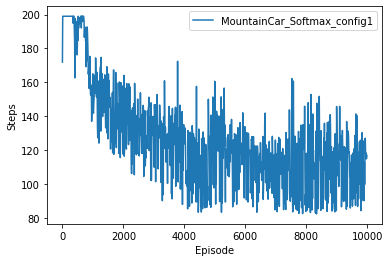

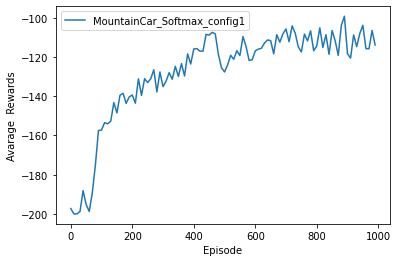

In [ ]:
detailsAfig1 = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig1)]
stepsconfig1=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig1)]
detailsconfig1avg =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig1avg)]

plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig1))*10,stepsconfig2,LABEL='MountainCar_config1')
plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsconfig1avg[0]))*10,detailsconfig1avg[0])


plt.show()



## Configuration 2

In [ ]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE =64         #''' minibatch size '''
GAMMA = 0.99        #''' discount factor '''
LR =0.01             #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''

detailsconfig2avg=[]
detailsconfig2=[]
stepsconfig2=[]
for i in range(10):
  print('start experiment'+str(i+1))
  env = gym.make('MountainCar-v0')
  env.seed(0)
  state_shape = env.observation_space.shape[0]
  no_of_actions = env.action_space.n
  state = env.reset()   
  begin_time = datetime.datetime.now()
  agent = Agent(state_size=state_shape,action_size = action_shape,seed = 0,\
             fc1_units=64, fc2_units=64,optimizer='nadam',momentum_decay=0.99)
  details2avg,details2,steps=dqn(agent=agent,n_episodes=1000,method='epsilon',\
                     eps_start=1,buffer_size =BUFFER_SIZE,\
                    batch_size = BATCH_SIZE ,gamma = GAMMA,\
                    LR = LR,update_every = UPDATE_EVERY,\
                    eps_decay=0.01,scoreThreshold=-80)
  
  time_taken = datetime.datetime.now() - begin_time
  detailsconfig2.append(details2)
  detailsconfig2avg.append(details2avg)
  stepsconfig2.append(steps)

  print(time_taken)
  print('Complete experiment'+str(i+1))

start experiment1
Episode 100	Average Score: -186.87
Episode 200	Average Score: -151.94
Episode 300	Average Score: -118.26
Episode 400	Average Score: -121.58
Episode 500	Average Score: -107.16
Episode 600	Average Score: -127.85
Episode 700	Average Score: -125.57
Episode 800	Average Score: -114.31
Episode 900	Average Score: -105.18
Episode 1000	Average Score: -103.64
0:08:57.089695
Complete experiment1
start experiment2
Episode 100	Average Score: -186.87
Episode 200	Average Score: -151.94
Episode 300	Average Score: -118.26
Episode 400	Average Score: -121.58
Episode 500	Average Score: -107.16
Episode 600	Average Score: -127.85
Episode 700	Average Score: -125.57
Episode 800	Average Score: -114.31
Episode 900	Average Score: -105.18
Episode 1000	Average Score: -103.64
0:08:52.451815
Complete experiment2
start experiment3
Episode 100	Average Score: -186.87
Episode 200	Average Score: -151.94
Episode 300	Average Score: -118.26
Episode 400	Average Score: -121.58
Episode 500	Average Score: -107.

In [ ]:
detailsAfig2 = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig2)]
stepsconfig2=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig2)]
detailsconfig2avg =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig2avg)]

plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig2))*10,stepsconfig2,LABEL='MountainCar_config2')
plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsconfig2avg[0]))*10,detailsconfig2avg[0])


plt.show()



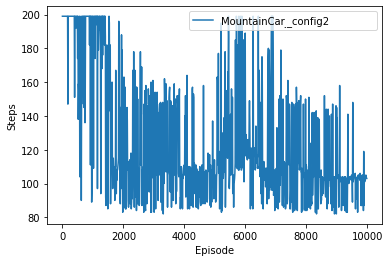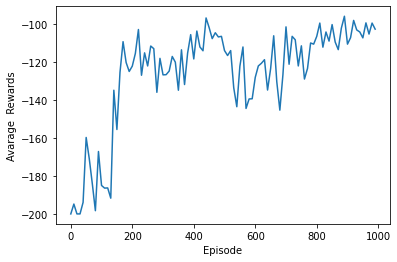

### Configuration 3

In [ ]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE = 64         #''' minibatch size '''
GAMMA = 0.99            #''' discount factor '''
LR = .001              #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''


detailsconfig3avg=[]
detailsconfig3=[]
stepsconfig3=[]
for i in range(10):
  print('start experiment'+str(i+1))
  env = gym.make('MountainCar-v0')
  env.seed(0)
  state_shape = env.observation_space.shape[0]
  no_of_actions = env.action_space.n
  state = env.reset()   
  begin_time = datetime.datetime.now()
  agent = Agent(state_size=state_shape,action_size = action_shape,seed = 0,\
               fc1_units=64, fc2_units=64,optimizer='adam')
  details3avg,details3,steps=dqn(agent=agent,n_episodes=1000,method='softmax',temperature=0.001,\
                      buffer_size =BUFFER_SIZE,\
                      batch_size = BATCH_SIZE ,gamma = GAMMA,\
                      LR = LR,update_every = UPDATE_EVERY,\
                      scoreThreshold=-50.0)#,temperature=0.9)
  time_taken = datetime.datetime.now() - begin_time
  detailsconfig3.append(details3)
  detailsconfig3avg.append(details3avg)
  stepsconfig3.append(steps)

  print(time_taken)
  print('Complete experiment'+str(i+1))

start experiment1
Episode 100	Average Score: -186.03
Episode 200	Average Score: -129.59
Episode 300	Average Score: -117.59
Episode 400	Average Score: -121.45
Episode 500	Average Score: -104.57
Episode 600	Average Score: -105.27
Episode 700	Average Score: -102.94
Episode 800	Average Score: -116.37
Episode 900	Average Score: -113.25
Episode 1000	Average Score: -104.91
0:07:11.204417
Complete experiment1
start experiment2
Episode 100	Average Score: -193.70
Episode 200	Average Score: -147.68
Episode 300	Average Score: -129.09
Episode 400	Average Score: -133.63
Episode 500	Average Score: -112.66
Episode 600	Average Score: -127.55
Episode 700	Average Score: -123.26
Episode 800	Average Score: -108.14
Episode 900	Average Score: -106.01
Episode 1000	Average Score: -104.19
0:08:04.719384
Complete experiment2
start experiment3
Episode 100	Average Score: -198.00
Episode 200	Average Score: -188.53
Episode 300	Average Score: -122.23
Episode 400	Average Score: -117.29
Episode 500	Average Score: -116.

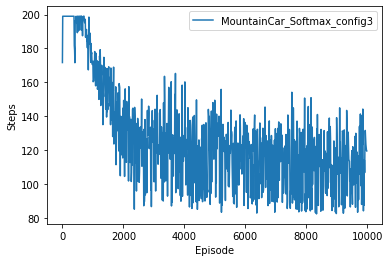

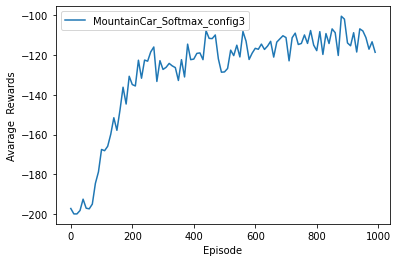

In [ ]:
detailsAfig3 = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig3)]
stepsconfig3=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig3)]
detailsconfig3avg =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig3avg)]

plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig3)),stepsconfig3,LABEL='MountainCar_Softmax_config3')
plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsconfig3avg[0]))*10,detailsconfig3avg[0],LABEL='MountainCar_Softmax_config3')

plt.legend()
plt.show()



### Configuration 4

In [8]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE = 64         #''' minibatch size '''
GAMMA = 0.99            #''' discount factor '''
LR = .001              #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''


detailsconfig4avg=[]
detailsconfig4=[]
stepsconfig4=[]
for i in range(10):
  print('start experiment'+str(i+1))
  env = gym.make('MountainCar-v0')
  env.seed(0)
  state_shape = env.observation_space.shape[0]
  no_of_actions = env.action_space.n
  state = env.reset()   
  begin_time = datetime.datetime.now()
  agent = Agent(state_size=state_shape,action_size = action_shape,seed = 0,\
             fc1_units=64, fc2_units=128,optimizer='adam')
  details4avg,details4,steps=dqn(agent=agent,n_episodes=1000,method='softmax',temperature=0.001,\
                    buffer_size =BUFFER_SIZE,\
                    batch_size = BATCH_SIZE ,gamma = GAMMA,\
                    LR = LR,update_every = UPDATE_EVERY,\
                    scoreThreshold=-50.0)
  time_taken = datetime.datetime.now() - begin_time
  detailsconfig4.append(details4)
  detailsconfig4avg.append(details4avg)
  stepsconfig4.append(steps)

  print(time_taken)
  print('Complete experiment'+str(i+1))

start experiment1
Episode 100	Average Score: -191.06
Episode 200	Average Score: -152.14
Episode 300	Average Score: -126.34
Episode 400	Average Score: -138.69
Episode 500	Average Score: -117.72
Episode 600	Average Score: -119.13
Episode 700	Average Score: -109.70
Episode 800	Average Score: -113.29
Episode 900	Average Score: -118.04
Episode 1000	Average Score: -118.76
0:11:08.735978
Complete experiment1
start experiment2
Episode 100	Average Score: -195.15
Episode 200	Average Score: -179.83
Episode 300	Average Score: -139.39
Episode 400	Average Score: -130.77
Episode 500	Average Score: -121.18
Episode 600	Average Score: -117.94
Episode 700	Average Score: -123.76
Episode 800	Average Score: -120.53
Episode 900	Average Score: -115.09
Episode 1000	Average Score: -112.01
0:11:08.277994
Complete experiment2
start experiment3
Episode 100	Average Score: -200.00
Episode 200	Average Score: -199.96
Episode 300	Average Score: -200.00
Episode 400	Average Score: -200.00
Episode 500	Average Score: -200.

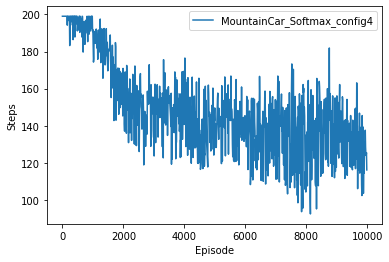

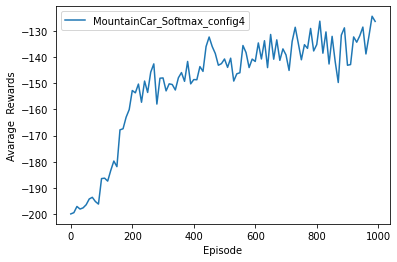

In [9]:
detailsAfig4 = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig4)]
stepsconfig4=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig4)]
detailsconfig4avg =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig4avg)]



plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig4))*10,stepsconfig4,LABEL='MountainCar_Softmax_config4')
plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsconfig4avg[0]))*10,detailsconfig4avg[0],LABEL='MountainCar_Softmax_config4')

plt.legend()
plt.show()



### Configuration 5

In [ ]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE = 64         #''' minibatch size '''
GAMMA = 0.5            #''' discount factor '''
LR = .001              #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''


detailsconfig3avg=[]
detailsconfig3=[]
stepsconfig3=[]
print('start')
for i in range(10):
 
  env = gym.make('MountainCar-v0')
  env.seed(0)
  state_shape = env.observation_space.shape[0]
  no_of_actions = env.action_space.n
  state = env.reset()   
  begin_time = datetime.datetime.now()
  agent = Agent(state_size=state_shape,action_size = action_shape,seed = 0,\
               fc1_units=64, fc2_units=64,optimizer='adam')
  details3avg,details3,steps=dqn(agent=agent,n_episodes=1000,method='softmax',temperature=0.001,\
                      buffer_size =BUFFER_SIZE,\
                      batch_size = BATCH_SIZE ,gamma = GAMMA,\
                      LR = LR,update_every = UPDATE_EVERY,\
                      scoreThreshold=-50.0)#,temperature=0.9)
  time_taken = datetime.datetime.now() - begin_time
  detailsconfig3.append(details3)
  detailsconfig3avg.append(details3avg)
  stepsconfig3.append(steps)



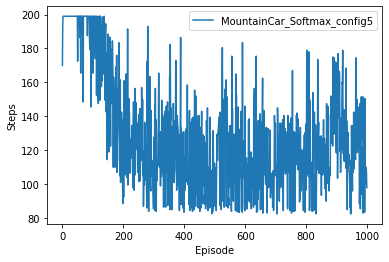

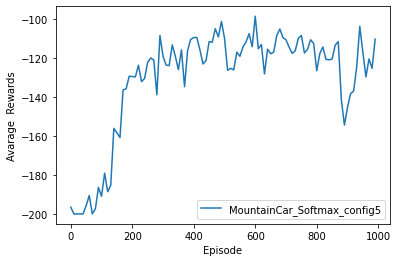

In [19]:
detailsAfig3 = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig3)]
stepsconfig3=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig3)]
detailsconfig3avg =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig3avg)]

plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig3)),stepsconfig3,LABEL='MountainCar_Softmax_config5')
plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsconfig3avg[0]))*10,detailsconfig3avg[0],LABEL='MountainCar_Softmax_config5')

plt.legend()
plt.show()



### Lowe beta value

In [ ]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE = 64         #''' minibatch size '''
GAMMA = 0.2           #''' discount factor '''
LR = .001              #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''


detailsconfig3avg=[]
detailsconfig3=[]
stepsconfig3=[]
print('start')
for i in range(10):

  env = gym.make('MountainCar-v0')
  env.seed(0)
  state_shape = env.observation_space.shape[0]
  no_of_actions = env.action_space.n
  state = env.reset()   
  begin_time = datetime.datetime.now()
  agent = Agent(state_size=state_shape,action_size = action_shape,seed = 0,\
               fc1_units=64, fc2_units=64,optimizer='adam')
  details3avg,details3,steps=dqn(agent=agent,n_episodes=1000,method='softmax',temperature=0.001,\
                      buffer_size =BUFFER_SIZE,\
                      batch_size = BATCH_SIZE ,gamma = GAMMA,\
                      LR = LR,update_every = UPDATE_EVERY,\
                      scoreThreshold=-50.0)#,temperature=0.9)
  time_taken = datetime.datetime.now() - begin_time
  detailsconfig3.append(details3)
  detailsconfig3avg.append(details3avg)
  stepsconfig3.append(steps)



In [ ]:
detailsAfig3 = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig3)]
stepsconfig3=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig3)]
detailsconfig3avg =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig3avg)]

plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig3)),stepsconfig3,LABEL='MountainCar_low_gamma')
plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsconfig3avg[0]))*10,detailsconfig3avg[0],LABEL='MountainCar_low_gamma')

plt.legend()
plt.show()



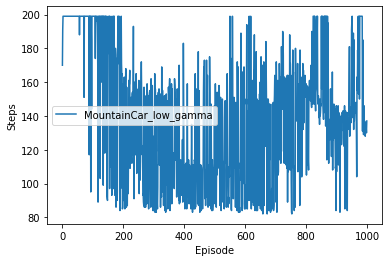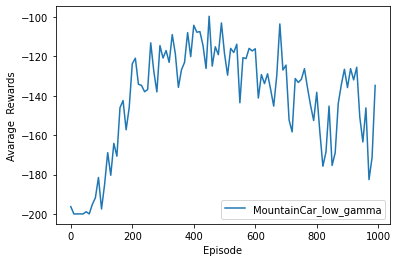

In [ ]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''
BUFFER_SIZE = int(1e5)  #''' replay buffer size '''
BATCH_SIZE =64         #''' minibatch size '''
GAMMA = 0.2       #''' discount factor '''
LR =0.01             #''' learning rate '''
UPDATE_EVERY = 20       #''' how often to update the network (When Q target is present) '''

detailsconfig2avg=[]
detailsconfig2=[]
stepsconfig2=[]
for i in range(10):

  env = gym.make('MountainCar-v0')
  env.seed(0)
  state_shape = env.observation_space.shape[0]
  no_of_actions = env.action_space.n
  state = env.reset()   
  begin_time = datetime.datetime.now()
  agent = Agent(state_size=state_shape,action_size = action_shape,seed = 0,\
             fc1_units=64, fc2_units=64,optimizer='nadam',momentum_decay=0.99)
  details2avg,details2,steps=dqn(agent=agent,n_episodes=1000,method='epsilon',\
                     eps_start=1,buffer_size =BUFFER_SIZE,\
                    batch_size = BATCH_SIZE ,gamma = GAMMA,\
                    LR = LR,update_every = UPDATE_EVERY,\
                    eps_decay=0.01,scoreThreshold=-80)
  
  time_taken = datetime.datetime.now() - begin_time
  detailsconfig2.append(details2)
  detailsconfig2avg.append(details2avg)
  stepsconfig2.append(steps)



In [ ]:
detailsAfig2 = [sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig2)]
stepsconfig2=[sum(sub_list) / len(sub_list) for sub_list in zip(*stepsconfig2)]
detailsconfig2avg =[sum(sub_list) / len(sub_list) for sub_list in zip(*detailsconfig2avg)]

plt.xlabel('Episode')
plt.ylabel('Steps')
plt.plot(np.arange(len(stepsconfig2))*10,stepsconfig2,LABEL='MountainCar_low beta')
plt.legend()
plt.show()

plt.xlabel('Episode')
plt.ylabel('Avarage  Rewards')
plt.plot(np.arange(len(detailsconfig2avg[0]))*10,detailsconfig2avg[0])


plt.show()



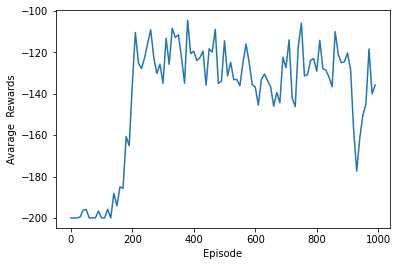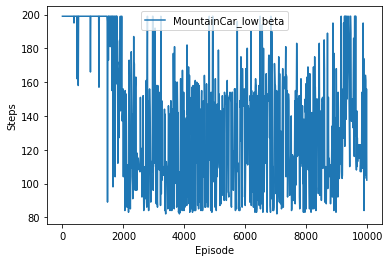